# Training

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

%matplotlib inline
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('data/preprocessed/data_mv_replaced.csv')

X = data.drop(['Severita', 'AHI'], axis=1).values
labels = data['Severita'].values.reshape(len(data), 1)  # shape (313, 1)
Y = OneHotEncoder(sparse=False).fit_transform(labels)   # shape (313, 4) - one hot encoded
y = labels.reshape(len(labels),)                        # shape (313,) - non one hot encoded

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Data shape:\t', data.shape, '\nTrain size:\t', X_train.shape[0], '\nTest size:\t', X_test.shape[0])

Data shape:	 (313, 21) 
Train size:	 250 
Test size:	 63


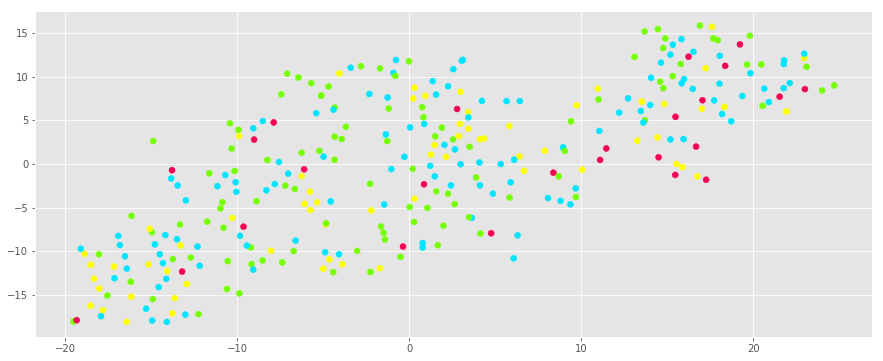

In [6]:
def get_color(n):
    #         0.orange,  1.fuchsia, 2.yellow,  3.lgt-blue, 4.green,  5.blue,    6.white,   7.violet
    colors = ["#FF8F00", "#F50057", "#FFFF00", "#00E5FF", "#76FF03", "#2979FF", "#FFFFFF", "#9C27B0"]
    color = ""
    if n < 0:
        color = "#009688" # noise
    elif n < len(colors):
        color = colors[n]
    else:
        color = "#" + format(n**5, '06X')
    return color

def plot_curves(acc, costs):
    plt.rcParams["figure.figsize"] = [20, 3]
    plt.suptitle('Accuracy', fontsize=14)
    plt.plot(acc, label="acc")
    plt.show()
    plt.suptitle('Cost', fontsize=14)
    plt.plot(costs, label="cost")
    plt.show()

colors  = [get_color(i) for i in y]
twodims = TSNE(n_components=2).fit_transform(X)

plt.rcParams["figure.figsize"] = [15, 6]
plot_x = [point[0] for point in twodims]
plot_y = [point[1] for point in twodims]
plt.scatter(plot_x, plot_y, color=colors)
plt.show()

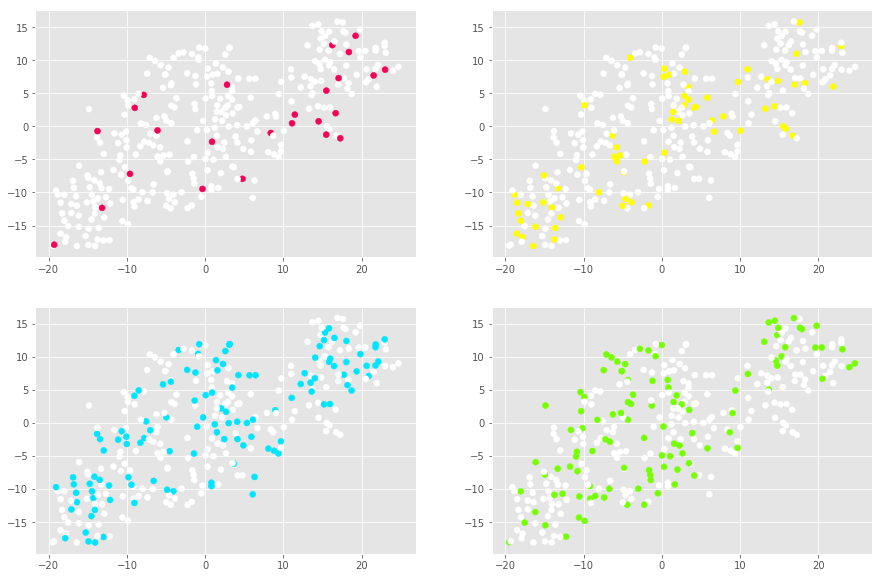

In [7]:
plt.rcParams["figure.figsize"] = [15, 10]
fig, ax = plt.subplots(nrows=2,ncols=2)

for i in range(1, 5):
    colors = [get_color(cls) if cls == i else '#FFFFFF' for cls in y]
    plt.subplot(2, 2, i)
    plt.scatter(plot_x, plot_y, color=colors)

plt.show()

#### Layer templates

In [8]:
def dense_layer(x, size_in, size_out, name="dense"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1))
        b = tf.Variable(tf.constant(0.1, shape=[size_out]))
        act = tf.matmul(x, w) + b
        return act

def conv_layer(x, kernel_size=19, size_in=1, size_out=1, name="conv"):
    with tf.name_scope(name):
        kernel = tf.Variable(tf.truncated_normal([1, kernel_size, size_in, size_out], stddev=0.1), name="kernel")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        return tf.nn.max_pool(act, ksize=[1, 1, size_out, 1], strides=[1, 1, 1, 1], padding="VALID")

### Building the computational graph

In [9]:
def create_network(layers, learn_rate=0.003, dropout=1, activation=tf.nn.relu, optimizer=tf.train.AdamOptimizer):
    x = tf.placeholder('float', [None, 19])
    y = tf.placeholder('float')
    drop_out = tf.nn.dropout(x, dropout)
    flow = [drop_out]
    for i in range(1, len(layers)):
        num_neurons_in  = layers[i-1]
        num_neurons_out = layers[i]
        layer = dense_layer(flow[-1], num_neurons_in, num_neurons_out, "layer" + str(i))
        flow.append(layer if i == len(layers)-1 else activation(layer))
    
    saver = tf.train.Saver()

    predictions = tf.argmax(input=flow[-1], axis=1)
    probs = tf.nn.softmax(flow[-1], name="softmax_tensor")
    
    xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flow[-1], labels=y), name="xent")
    train_step = optimizer(learn_rate).minimize(xent)

    correct_prediction = tf.equal(tf.argmax(flow[-1], 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    
    return {'train_step': train_step, 'loss': xent, 'accuracy': accuracy, 
            'predict': predictions, 'probabilities': probs, 
            'input': x, 'output': y, 
            'saver': saver}

def create_conv_network(layers, dropout=1, kernel_size=19, size_in=1, size_out=1, learn_rate=0.003, activation=tf.nn.relu, optimizer=tf.train.AdamOptimizer):
    x = tf.placeholder('float', [None, 19])
    y = tf.placeholder('float')
    xr = tf.reshape(x, [-1, 1, 19, 1])
    # xt = x.reshape(250, 1, 19, 1).astype(np.float32)
    
    convolve = conv_layer(xr, kernel_size=19, size_in=1, size_out=1)
    drop_out = tf.nn.dropout(convolve, dropout)
    reshaped = tf.reshape(drop_out, [-1, 19])
    flow = [reshaped]
    for i in range(1, len(layers)):
        num_neurons_in  = layers[i-1]
        num_neurons_out = layers[i]
        layer = dense_layer(flow[-1], num_neurons_in, num_neurons_out, "layer" + str(i))
        flow.append(layer if i == len(layers)-1 else activation(layer))
    
    saver = tf.train.Saver()
    
    predictions = tf.argmax(input=flow[-1], axis=1)
    probs = tf.nn.softmax(flow[-1], name="softmax_tensor")
    
    xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flow[-1], labels=y), name="xent")
    train_step = optimizer(learn_rate).minimize(xent)

    correct_prediction = tf.equal(tf.argmax(flow[-1], 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    
    return {'train_step': train_step, 'loss': xent, 'accuracy': accuracy, 
            'predict': predictions, 'probabilities': probs, 
            'input': x, 'output': y, 
            'saver': saver}

### Training

In [10]:
get_batches = lambda data, size: [data[i:i+size] for i in range(0, len(data), size)]

def train(net, train_x, train_y, test_x, test_y, epochs, batch_size):
    x_batches = get_batches(train_x, batch_size)
    y_batches = get_batches(train_y, batch_size)
    accuracies, costs = [], []
    for epoch in range(epochs):
        for i in range(len(x_batches)):
            _, cost = sess.run([net['train_step'], net['loss']], feed_dict={net['input']: x_batches[i], net['output']: y_batches[i]})
            acc = sess.run(net['accuracy'], feed_dict={net['input']: test_x, net['output']: test_y})      
        if epoch % 10 == 0:
            costs.append(cost)
            accuracies.append(acc)
    return accuracies, costs

#### Dense Net

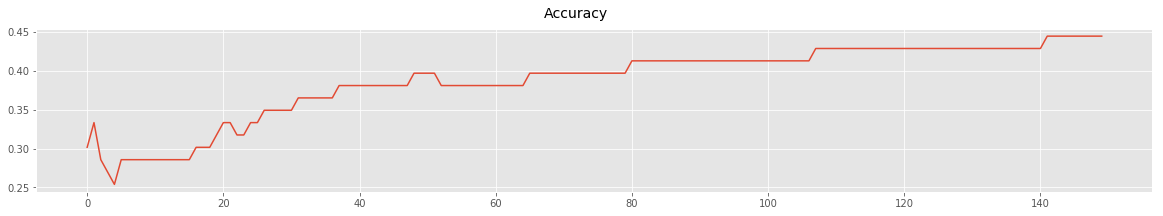

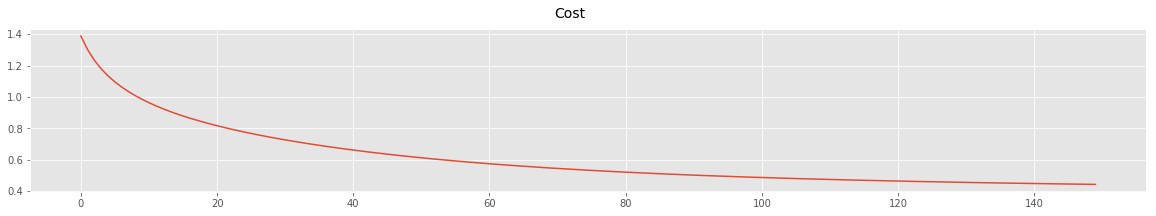

In [111]:
with tf.Session() as sess:
    net = create_network([19, 4])
    sess.run(tf.global_variables_initializer())
    acc, costs = train(net, X_train, Y_train, X_test, Y_test, 1500, 80)
    save_path = net['saver'].save(sess, "./tmp/model.ckpt")

plot_curves(acc, costs)

#### Convolutional Net

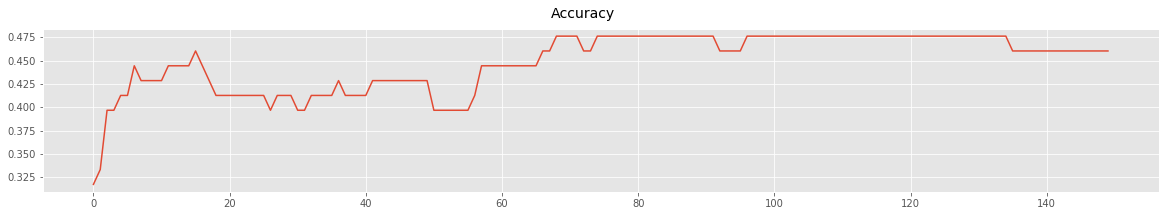

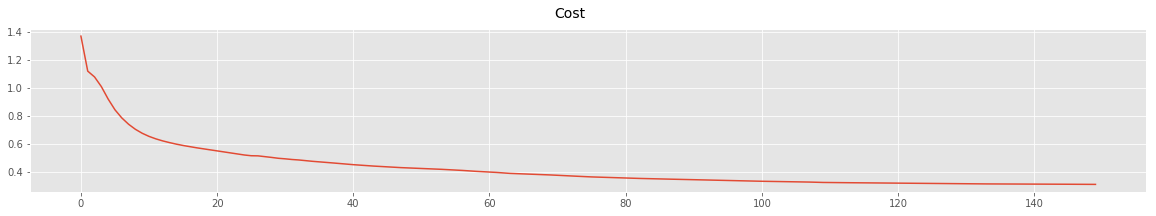

In [89]:
with tf.Session() as sess:
    conv_net = create_conv_network([19, 4], kernel_size=19, size_in=1, size_out=4)
    sess.run(tf.global_variables_initializer())
    acc, costs = train(conv_net, X_train, Y_train, X_test, Y_test, 1500, 40)
    save_path = net['saver'].save(sess, "./tmp/model_conv.ckpt")
    
plot_curves(acc, costs)

### Prediction

In [187]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    net['saver'].restore(sess, "./tmp/model.ckpt");
    pred = sess.run(net['predict'], feed_dict={net['input']: X_train[n].reshape(1, 19)})
    print(pred)

[ 0.  0.  0.  1.]
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


[3]


---

## Evaluation
#### Cross Validation

In [11]:
def cross_validation_score(network, x, y, epochs, batch_size):
    skf = StratifiedKFold(n_splits=10)
    tot_acc = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        sess.run(tf.global_variables_initializer())
        acc, costs = train(network, x_train, y_train, x_test, y_test, epochs, batch_size)
        curr_acc = acc[-1]
        tot_acc.append(curr_acc)    
    return sum(tot_acc) / len(tot_acc) 

#### 10 fold Cross Validation

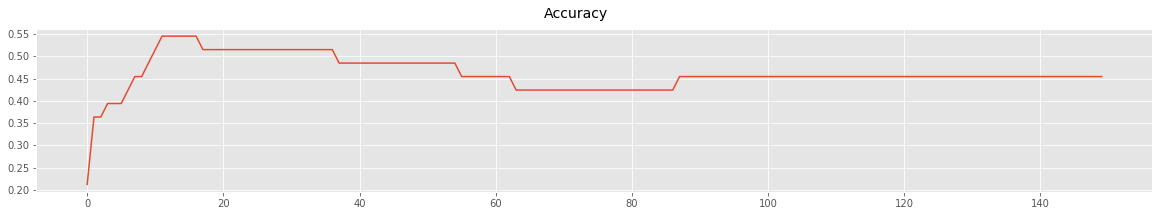

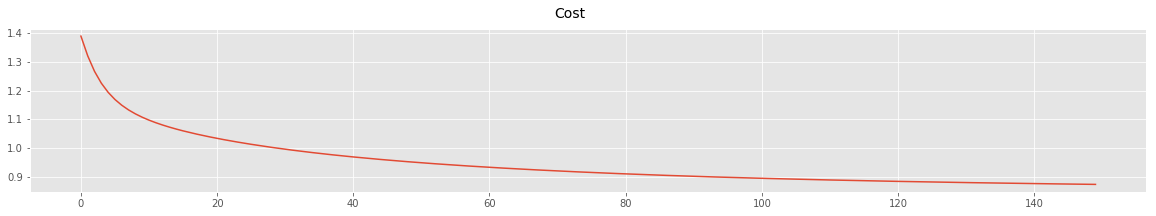

0.454545


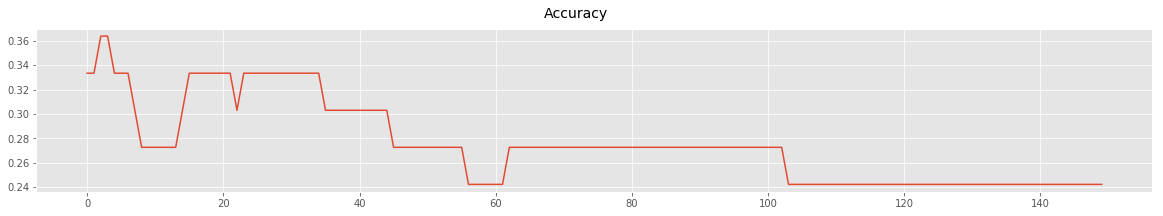

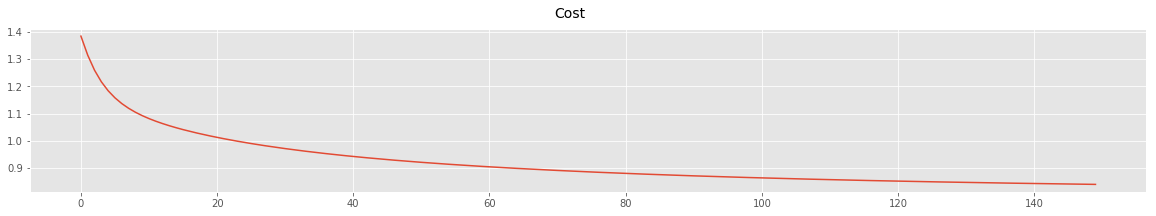

0.242424


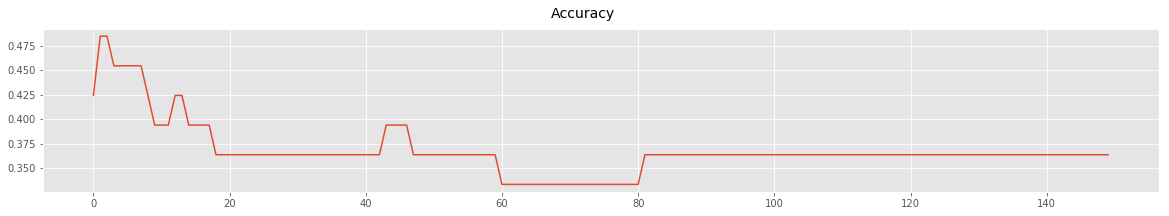

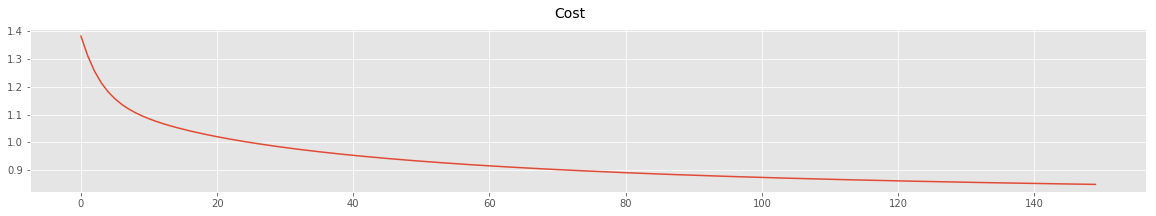

0.363636


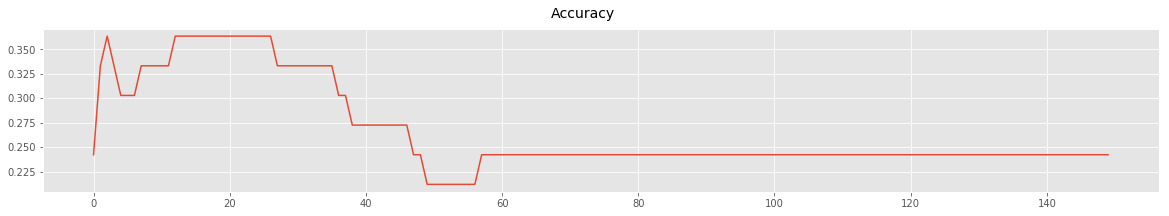

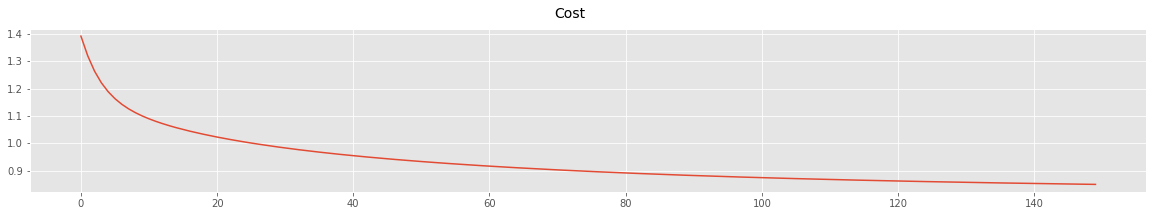

0.242424


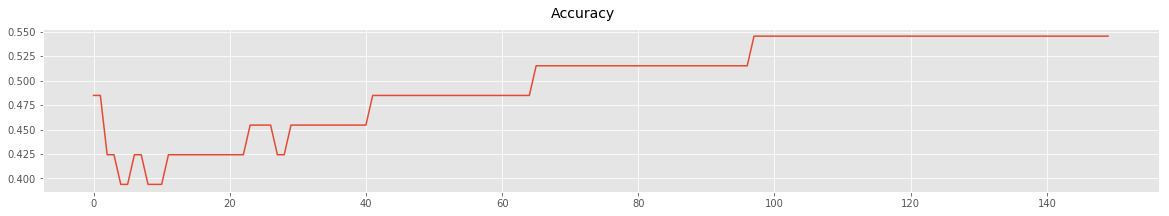

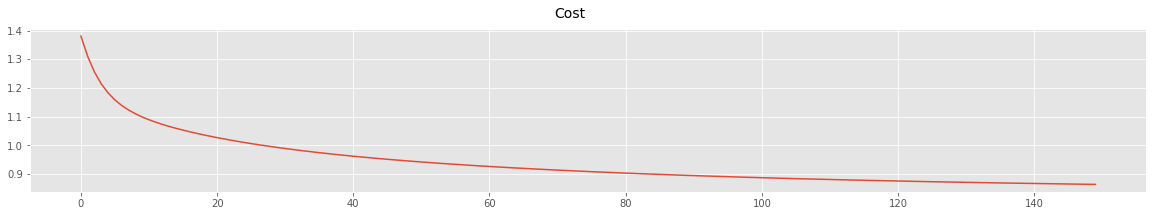

0.545455


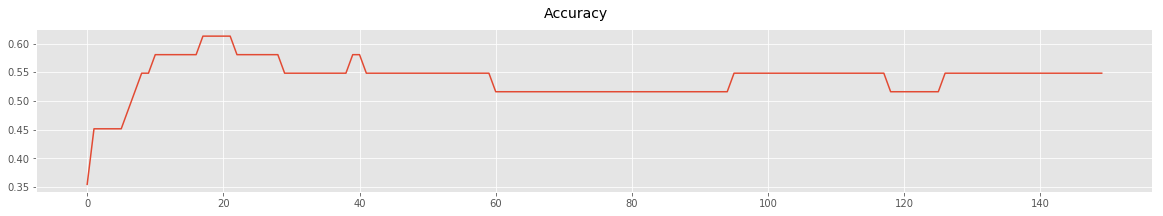

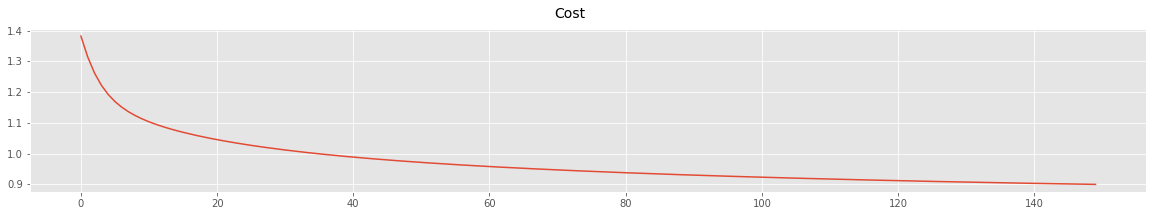

0.548387


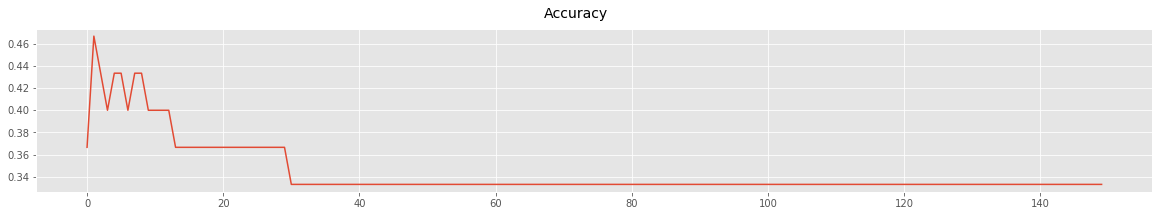

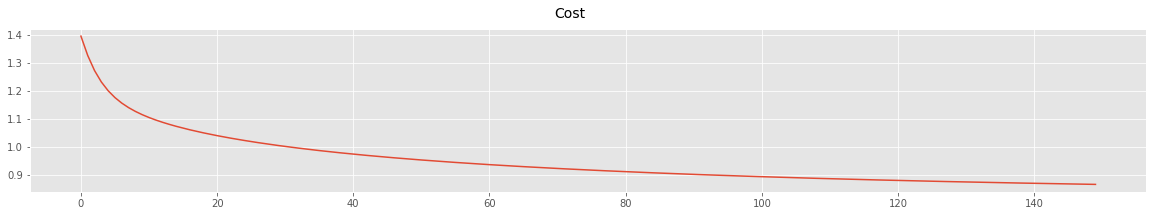

0.333333


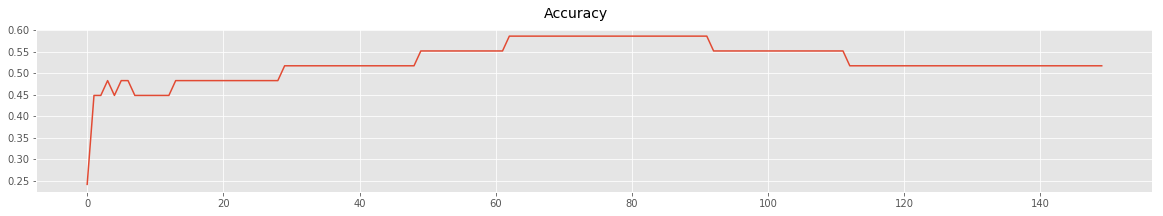

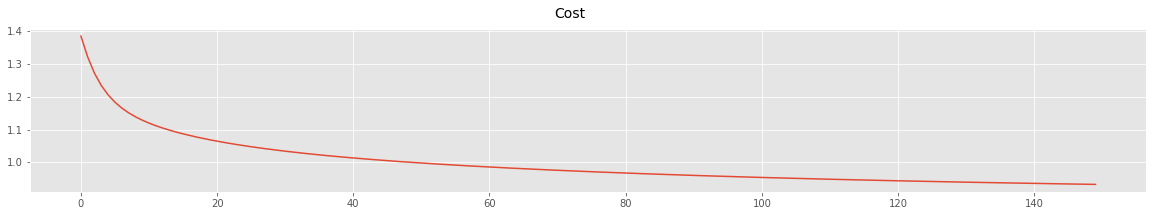

0.517241


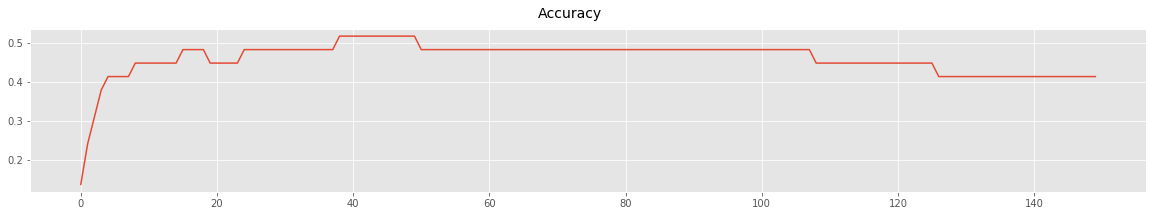

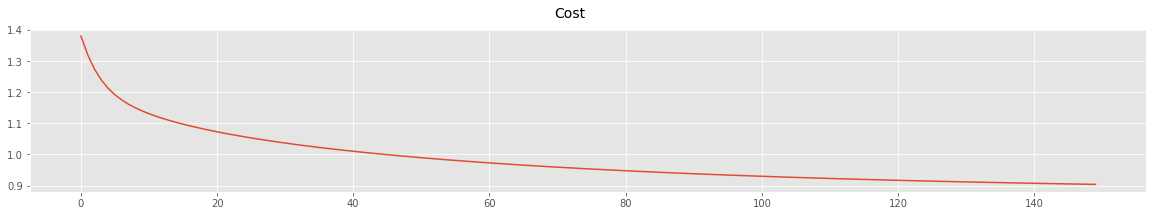

0.413793


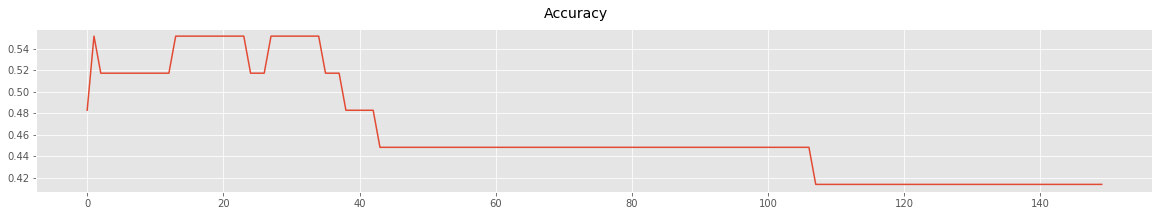

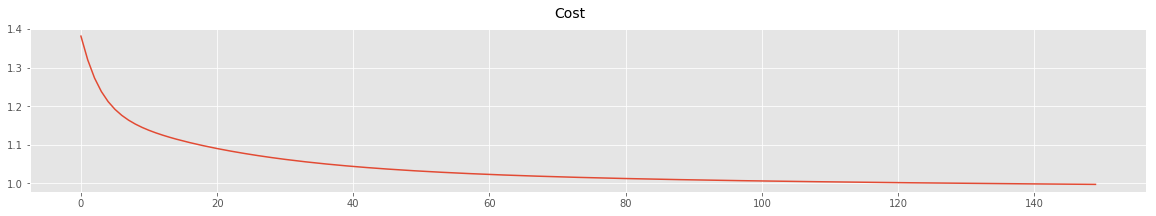

0.413793
0.407503294945


In [129]:
skf = StratifiedKFold(n_splits=10)
tot_acc = []

for train_index, test_index in skf.split(X, y):
    # print(len([c for c in y[test_index] if c == 3]))
    # print("TRAIN:", train_index, "\nTEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    with tf.Session() as sess:
        net = create_network([19, 4])
        sess.run(tf.global_variables_initializer())
        acc, costs = train(net, X_train, Y_train, X_test, Y_test, 1500, 80)
        save_path = net['saver'].save(sess, "./tmp/model.ckpt")
        plot_curves(acc, costs)
        curr_acc = acc[-1]
        print(curr_acc)
        tot_acc.append(curr_acc)    
print( sum(tot_acc)/len(tot_acc) )

#### Dense evaluation

In [14]:
%%time
# create_network(layers, learn_rate=0.003, dropout=1, activation=tf.nn.relu, optimizer=tf.train.AdamOptimizer)
dense_params_to_string = lambda arch, lr, batch_size: str('-'.join([str(i) for i in arch])) +  '__' + str(lr) + '__' + str(batch_size)
dense_scores = pd.DataFrame(columns=['10 Fold CV score - DENSE'])
with tf.Session() as sess:
    # net = create_network([19, 7, 4])
    for arch in [[19,4], [19,10,4], [19,7,4], [19,4,4]]:
        for learn_rate in [0.002, 0.003]:
            for batch_size in [10, 100, len(X_train)]:
                net = create_network(arch, learn_rate=learn_rate)
                sess.run(tf.global_variables_initializer())
                params = dense_params_to_string(arch, learn_rate, batch_size)
                cv_score = cross_validation_score(net, X, y, 1500, batch_size)
                dense_scores = dense_scores.append(pd.DataFrame([cv_score], index=[params], columns=['10 Fold CV score - DENSE']))


dense_scores

CPU times: user 1h 47min 22s, sys: 10min 33s, total: 1h 57min 55s
Wall time: 1h 13min 22s


In [209]:
dense_scores

,10 Fold CV score - DENSE
19-4__0.002__10,0.358233
19-4__0.002__100,0.388014
19-4__0.002__250,0.392992
19-4__0.003__10,0.359602
19-4__0.003__100,0.377474
19-4__0.003__250,0.389962
19-10-4__0.002__10,0.403434
19-10-4__0.002__100,0.391685
19-10-4__0.002__250,0.389383
19-10-4__0.003__10,0.360670


#### conv

In [12]:
%%time
# create_conv_network(layers, kernel_size=19, size_out=1, learn_rate=0.003):
conv_params_to_string = lambda arch, kernel_size, num_of_kernels, lr, batch_size: str('-'.join([str(i) for i in arch])) +  '__' + str(kernel_size) +  '__' + str(num_of_kernels) +  '__' + str(lr) + '__' + str(batch_size)
conv_scores = pd.DataFrame(columns=['10 Fold CV score - CONV'])
with tf.Session() as sess:
    # net = create_network([19, 7, 4])
    for arch in [[19,4], [19,10,4]]:
        for kernel_size in [19, 1]:
            for num_of_kernels in [1, 3]:
                for learn_rate in [0.002, 0.003]:
                    for batch_size in [10, 100, len(X_train)]:
                        conv_net = create_conv_network(arch, kernel_size=kernel_size, size_out=num_of_kernels, learn_rate=learn_rate)
                        sess.run(tf.global_variables_initializer())
                        params = conv_params_to_string(arch, kernel_size, num_of_kernels, learn_rate, batch_size)
                        cv_score = cross_validation_score(conv_net, X, y, 1500, batch_size)
                        conv_scores = conv_scores.append(pd.DataFrame([cv_score], index=[params], columns=['10 Fold CV score - CONV']))
                        print(params, cv_score)


conv_scores

CPU times: user 5h 25min 36s, sys: 1h 11min 4s, total: 6h 36min 41s
Wall time: 3h 40min 33s


In [13]:
conv_scores

,10 Fold CV score - CONV
19-4__19__1__0.002__10,0.392510
19-4__19__1__0.002__100,0.398892
19-4__19__1__0.002__250,0.359583
19-4__19__1__0.003__10,0.425758
19-4__19__1__0.003__100,0.418889
19-4__19__1__0.003__250,0.393757
19-4__19__3__0.002__10,0.382701
19-4__19__3__0.002__100,0.373830
19-4__19__3__0.002__250,0.377777
19-4__19__3__0.003__10,0.386726


---

## Other methods

In [115]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=0) # .fit(X_train, y_train)
scores = cross_val_score(clf, X, y, cv=10)
scores.mean()

0.34374928371591335

#### One vs One and One vs Rest

In [148]:
ovo_svm    = OneVsOneClassifier(SVC(kernel='rbf', gamma=2, C=1))
ovo_forest = OneVsOneClassifier(RandomForestClassifier(n_estimators=10, max_features=1))
ovo_boost  = OneVsOneClassifier(clf)

ovr_svm    = OneVsRestClassifier(SVC(kernel='rbf', gamma=2, C=1))
ovr_forest = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, max_features=1))
ovr_boost  = OneVsRestClassifier(clf)

In [161]:
pd.DataFrame([
    cross_val_score(ovo_svm, X, y, cv=10).mean(),
    cross_val_score(ovo_forest, X, y, cv=10).mean(),
    cross_val_score(ovo_boost, X, y, cv=10).mean(),
    cross_val_score(ovr_svm, X, y, cv=10).mean(),
    cross_val_score(ovr_forest, X, y, cv=10).mean(),
    cross_val_score(ovr_boost, X, y, cv=10).mean(),
    ],
    index=['OvO SVM', 'OvO Forest', 'OvO Boost', 'OvR SVM', 'OvR Forest', 'OvR Boost'],
    columns=['Cross Validation Score']
)

,Cross Validation Score
OvO SVM,0.380995
OvO Forest,0.385805
OvO Boost,0.338265
OvR SVM,0.380995
OvR Forest,0.374382
OvR Boost,0.354494
